In [149]:
#Version 15
#change : HUGE cleanup, most of code is in functions now
#change : it saves all information about current experiment into one folder containing model, 
#generatorsettings, accuracy plot and modelcheckpoints

# to fix - permissions to delete folders


In [150]:
#all imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import csv
import imageio
from datetime import datetime
import pwd
import grp
import shutil
import json

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from keras import backend as K
from keras.optimizers import SGD
from keras import regularizers


In [151]:
K.set_image_dim_ordering('th')
seed = 7
np.random.seed(seed)

#print start

In [152]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def readimagesfromfolder(path, color, show):
	imagepackage_list = []
	imagepackage = []
	imagelist = []
	filelist = sorted(os.listdir(path))
	for filename in filelist:
		fullfilename =  path + filename
		#print(fullfilename)        
		singleimage = imageio.imread(fullfilename)
		singleimage = cv2.resize(singleimage,(96,96), interpolation=cv2.INTER_AREA)        
		singleimage = rgb2gray(singleimage)
		#print(singleimage)        
		if show==1:
			plt.imshow(singleimage)
			plt.show()
		imagepackage.append(singleimage)
		imagepackage_list.append(imagepackage)        
		imagepackage = []        
	#print(len(imagepackage))        
	imagepackage_list = np.float32(imagepackage_list)
	#cv2.destroyAllWindows()
	return imagepackage_list

def readlabelfromcsv(filename):
    training_y = []
    with open(filename) as f:
        #training_y.append(f.readline())
        content = csv.reader(f)
        for line in content:
            #print(line[0])
            training_y.append(int(line[0]))
    return training_y


In [153]:
       
folderpath = 'data/basic/training/'
X_train=readimagesfromfolder(folderpath, 0, 0)

folderpath = 'data/basic/test/'
X_test=readimagesfromfolder(folderpath, 0, 0)

y_train = readlabelfromcsv("data/basic/training.csv")
y_test = readlabelfromcsv("data/basic/test.csv")


# check data shape
#print(np.shape(X_train))
#print(np.shape(X_test))

#print(y_train)
#print(np.shape(y_train))

#print(y_test)
#print(np.shape(y_test))

generator_settings = {
    "featurewise_center": False,  
    "samplewise_center" : False,  
    "featurewise_std_normalization" : False, 
    "samplewise_std_normalization" : False,  
    "zca_whitening": False,  
    "rotation_range": 10,
    "zoom_range" : 0.2,
    "width_shift_range": 0.3,  # randomly shift images horizontally (fraction of total width)
    "height_shift_range" :0.3,  # randomly shift images vertically (fraction of total height)
    "horizontal_flip": True,  # randomly flip images
    "vertical_flip": False,
    "fill_mode":"constant", 
    "cval":0}

datagen = ImageDataGenerator(**generator_settings) #unpacking dictionary values - beautiful isn't it? 

#datagen.fit(X_train) necessary only when using zca

(162, 1, 96, 96)


In [154]:


# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [155]:
def larger_model():
	# create model
	model = Sequential()
	model.add(Convolution2D(16, 3, 1, border_mode='same', input_shape=(1, 96, 96), activation='relu'))
	model.add(Convolution2D(24, 5, 3, border_mode='same', activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.2))
	model.add(Convolution2D(32, 5, 3, border_mode='same', activation='relu'))
	model.add(Convolution2D(48, 5, 3, border_mode='same', activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(1000, activation='relu'))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(50, activation='relu'))
	model.add(Dense(num_classes, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model




In [156]:
#saving everything in one folder
def plot_accuracy(path, history):
    figure = plt.figure(figsize=(20,20))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])

    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("model accuracy")
    plt.grid(True)

    plt.legend(["train", "test"], loc="upper left")
    plt.show()
    figure.savefig(path+"/accuracy.png")
    
def save_experiment(history, generator_settings):
    
    # created folder based on current time
    start = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")
    path = str(start)
    os.mkdir(path)
    
    #print history.history
    np.save(path + "/history", history.history)
    
    #save model scheme
    modelscheme = model.to_json()
    with open(path+"/modelscheme.json", "w+") as f:
        f.write(modelscheme)
        f.close()
    
    #create a plot with val accuracy    
    plot_accuracy(path, history)
    source = "modelcheckpoints"
    target = path
    shutil.move(source, target)
    
    #save generator settings
   
    with open(path+"/generator_settings.json","w+") as f:
        json.dump(generator_settings, f)
        f.close
    
    # trying to fix issues with permissions - still no luck
    uid = pwd.getpwnam("nobody").pw_uid
    gid = grp.getgrnam("nogroup").gr_gid
    os.chown(path, uid, gid)


    for dirpath, dirnames, filenames in os.walk('./'+path):
        for filename in filenames:
            path = os.path.join(dirpath, filename)
            os.chown(path, uid, gid) # for example
            os.chmod(path, 0o777)

def my_callbacks():
    os.mkdir("modelcheckpoints")
    filename = "modelcheckpoints/model_epoch_{epoch:02d}_val_acc_{val_acc:.2f}.hd5"
    earlystopping = EarlyStopping(monitor = "val_acc", patience = 20, verbose=1, mode="auto")
    checkpoint = ModelCheckpoint(filename, monitor = "val_acc", verbose =1, mode="auto", save_best_only = "True")
    list_of_callbacks = [earlystopping, checkpoint]
    return list_of_callbacks

Epoch 1/5
Epoch 00000: val_acc improved from -inf to 0.56250, saving model to modelcheckpoints/model_epoch_00_val_acc_0.56.hd5
21s - loss: 0.9883 - acc: 0.5090 - val_loss: 0.8284 - val_acc: 0.5625
Epoch 2/5
Epoch 00001: val_acc improved from 0.56250 to 0.79167, saving model to modelcheckpoints/model_epoch_01_val_acc_0.79.hd5
20s - loss: 0.7022 - acc: 0.7021 - val_loss: 0.5522 - val_acc: 0.7917
Epoch 3/5
Epoch 00002: val_acc did not improve
20s - loss: 0.5440 - acc: 0.7802 - val_loss: 0.7208 - val_acc: 0.7500
Epoch 4/5
Epoch 00003: val_acc improved from 0.79167 to 0.85417, saving model to modelcheckpoints/model_epoch_03_val_acc_0.85.hd5
20s - loss: 0.4155 - acc: 0.8325 - val_loss: 0.4314 - val_acc: 0.8542
Epoch 5/5
Epoch 00004: val_acc improved from 0.85417 to 0.87500, saving model to modelcheckpoints/model_epoch_04_val_acc_0.87.hd5
20s - loss: 0.2773 - acc: 0.8941 - val_loss: 0.4521 - val_acc: 0.8750


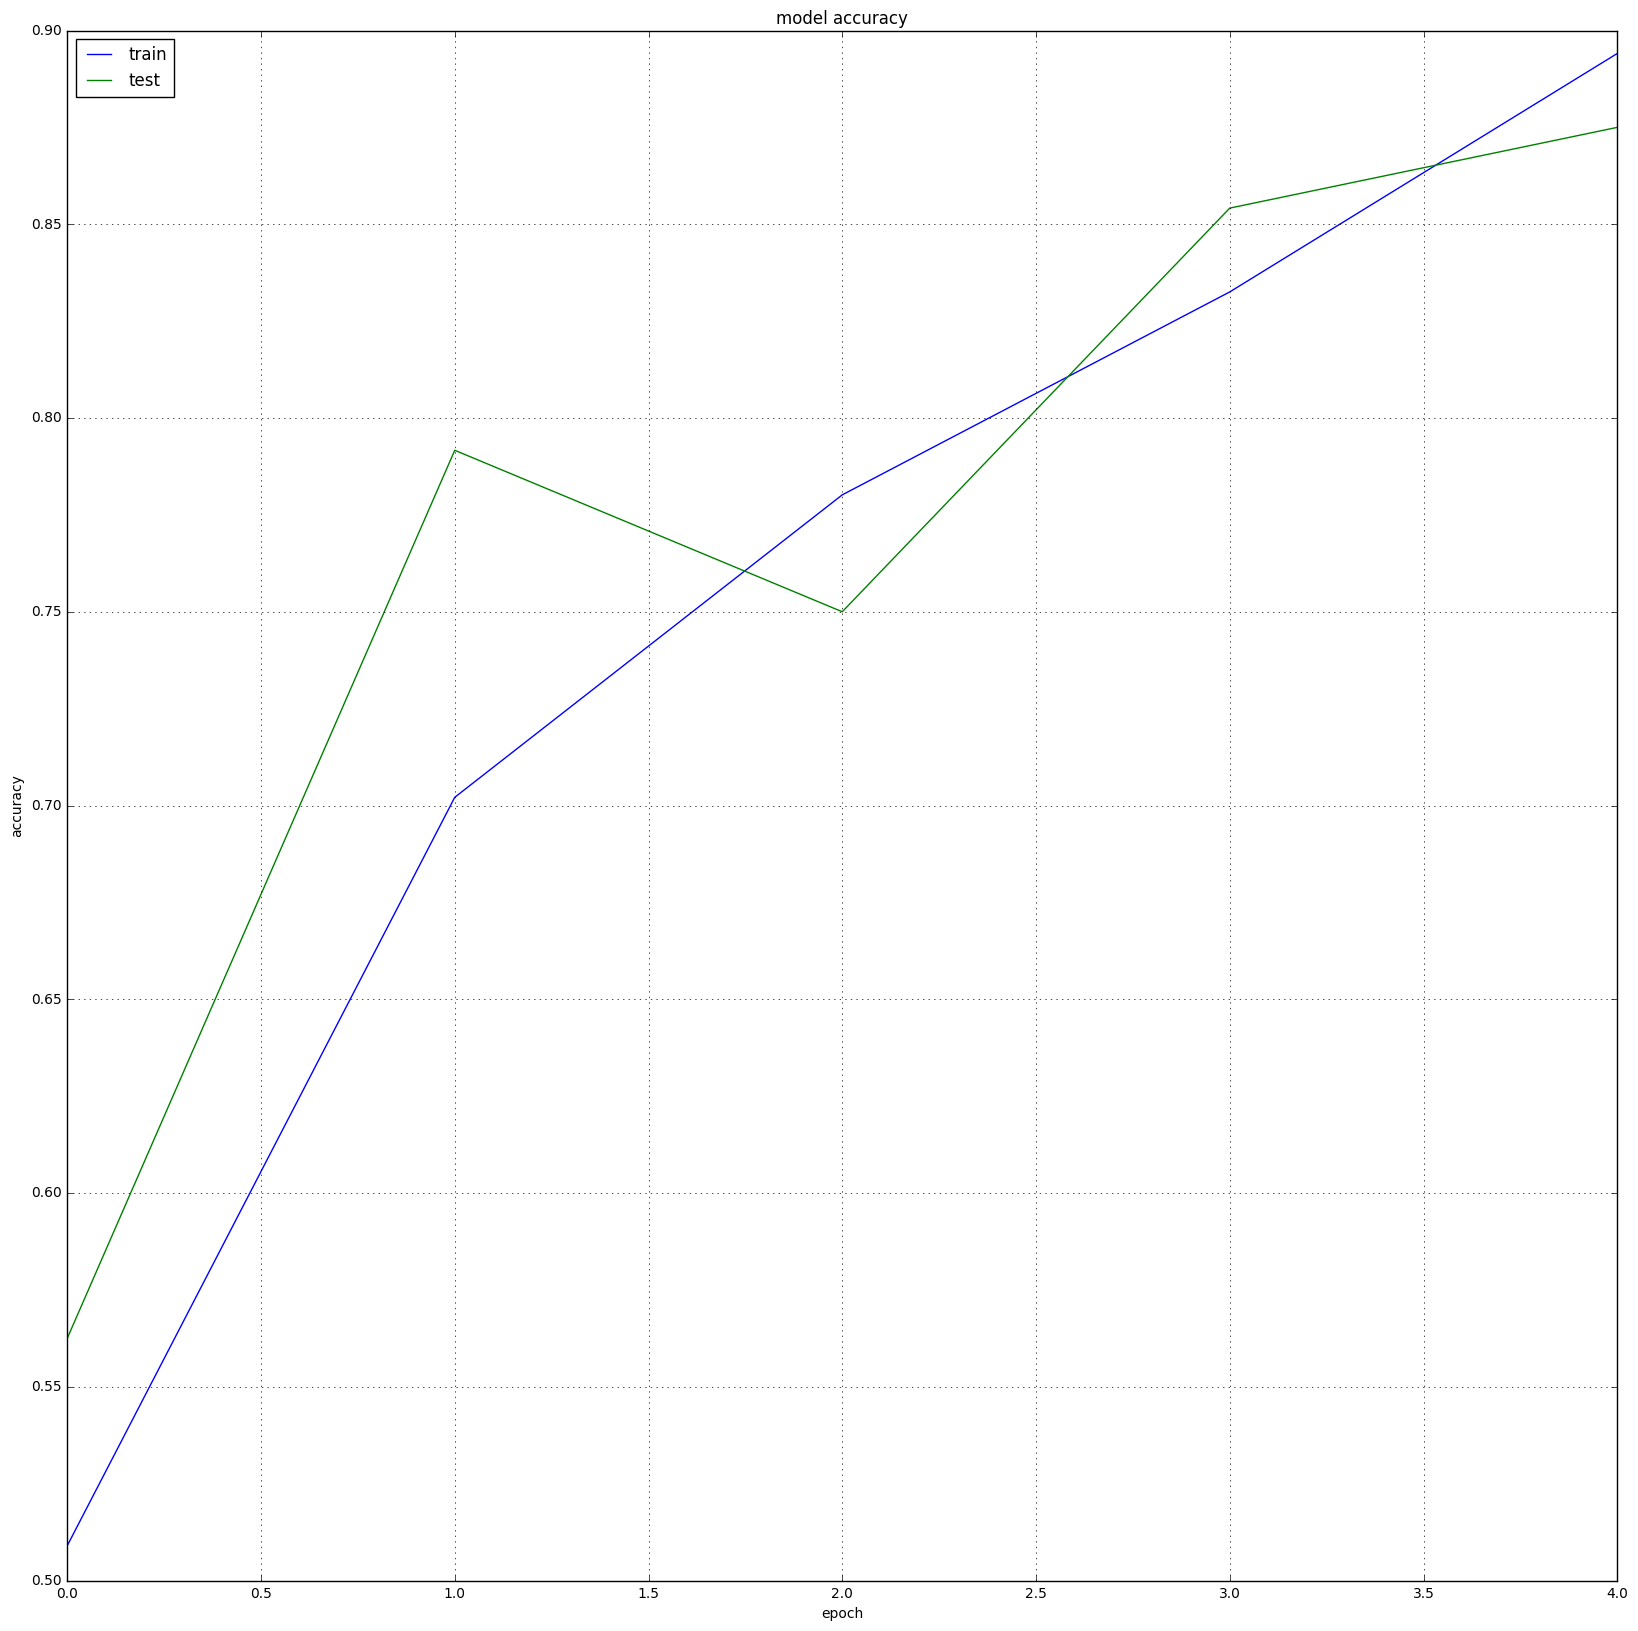

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_61 (Convolution2D) (None, 16, 96, 96)    64          convolution2d_input_16[0][0]     
____________________________________________________________________________________________________
convolution2d_62 (Convolution2D) (None, 24, 96, 96)    5784        convolution2d_61[0][0]           
____________________________________________________________________________________________________
maxpooling2d_31 (MaxPooling2D)   (None, 24, 48, 48)    0           convolution2d_62[0][0]           
____________________________________________________________________________________________________
dropout_31 (Dropout)             (None, 24, 48, 48)    0           maxpooling2d_31[0][0]            
___________________________________________________________________________________________

In [157]:
# build the model
model = larger_model()

# Fit the model
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=25), callbacks = my_callbacks(), samples_per_epoch = 5000, nb_epoch = 5, verbose=2, validation_data=(X_test, y_test))

# save all information about current experiment
save_experiment(history, generator_settings)
    
scores = model.evaluate(X_test, y_test, verbose=0)
print scores
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

